# Example 1: Preprocessing Workflow

This is meant as a very simple example for a preprocessing workflow. In this workflow we will conduct the following steps:

1. Motion correction of functional images with FSL's MCFLIRT
2. Coregistration of functional images to anatomical images (according to FSL's FEAT pipeline)
3. Smoothing of coregistrated functional images with FWHM set to 4mm and 8mm
4. Artifact Detection in functional images (to detect outlier volumes)

For every subject we have one anatomical T1w and 5 functional images. As a short recap, the image properties of the anatomy and the **fingerfootlips** functional image are:

In [3]:
%%bash
cd /data/ds000114/sub-01/ses-test
nib-ls a*/*.nii.gz f*/*fingerfootlips*.nii.gz

anat/sub-01_ses-test_T1w.nii.gz                      float32 [256, 156, 256]      1.00x1.30x1.00        sform
func/sub-01_ses-test_task-fingerfootlips_bold.nii.gz  int16  [ 64,  64,  30, 184] 4.00x4.00x4.00x2.50   sform



**So, let's start!**

## Imports

First, let's import all modules we later will be needing.

In [4]:
%matplotlib inline
from os.path import join as opj
import os
import json
from nipype.interfaces.fsl import (BET, ExtractROI, FAST, FLIRT, ImageMaths,
                                   MCFLIRT, SliceTimer, Threshold)
from nipype.interfaces.spm import Smooth
from nipype.interfaces.utility import IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.algorithms.rapidart import ArtifactDetect
from nipype.pipeline.engine import Workflow, Node

## Experiment parameters

It's always a good idea to specify all parameters that might change between experiments at the beginning of your script. We will use one functional image for fingerfootlips task for ten subjects.

In [5]:
experiment_dir = '/output'
output_dir = 'datasink'
working_dir = 'workingdir'

# list of subject identifiers
subject_list = ['sub-01', 'sub-02', 'sub-03', 'sub-04', 'sub-05',
                'sub-06', 'sub-07', 'sub-08', 'sub-09', 'sub-10']

# list of session identifiers
task_list = ['fingerfootlips']

# Smoothing widths to apply
fwhm = [4, 8]

# TR of functional images
with open('/data/ds000114/task-fingerfootlips_bold.json', 'rt') as fp:
    task_info = json.load(fp)
TR = task_info['RepetitionTime']

# Isometric resample of functional images to voxel size (in mm)
iso_size = 4

## Specify Nodes for the main workflow

Initiate all the different interfaces (represented as nodes) that you want to use in your workflow.

In [6]:
# ExtractROI - skip dummy scans
extract = Node(ExtractROI(t_min=4, t_size=-1),
               output_type='NIFTI',
               name="extract")

# MCFLIRT - motion correction
mcflirt = Node(MCFLIRT(mean_vol=True,
                       save_plots=True,
                       output_type='NIFTI'),
               name="mcflirt")

# SliceTimer - correct for slice wise acquisition
slicetimer = Node(SliceTimer(index_dir=False,
                             interleaved=True,
                             output_type='NIFTI',
                             time_repetition=TR),
                  name="slicetimer")

# Smooth - image smoothing
smooth = Node(Smooth(), name="smooth")
smooth.iterables = ("fwhm", fwhm)

# Artifact Detection - determines outliers in functional images
art = Node(ArtifactDetect(norm_threshold=2,
                          zintensity_threshold=3,
                          mask_type='spm_global',
                          parameter_source='FSL',
                          use_differences=[True, False],
                          plot_type='svg'),
           name="art")

## Coregistration Workflow

Initiate a workflow that coregistrates the functional images to the anatomical image (according to FSL's FEAT pipeline).

In [7]:
# BET - Skullstrip anatomical Image
bet_anat = Node(BET(frac=0.5,
                    robust=True,
                    output_type='NIFTI_GZ'),
                name="bet_anat")

# FAST - Image Segmentation
segmentation = Node(FAST(output_type='NIFTI_GZ'),
                name="segmentation")

# Select WM segmentation file from segmentation output
def get_wm(files):
    return files[-1]

# Threshold - Threshold WM probability image
threshold = Node(Threshold(thresh=0.5,
                           args='-bin',
                           output_type='NIFTI_GZ'),
                name="threshold")

# FLIRT - pre-alignment of functional images to anatomical images
coreg_pre = Node(FLIRT(dof=6, output_type='NIFTI_GZ'),
                 name="coreg_pre")

# FLIRT - coregistration of functional images to anatomical images with BBR
coreg_bbr = Node(FLIRT(dof=6,
                       cost='bbr',
                       schedule=opj(os.getenv('FSLDIR'),
                                    'etc/flirtsch/bbr.sch'),
                       output_type='NIFTI_GZ'),
                 name="coreg_bbr")

# Apply coregistration warp to functional images
applywarp = Node(FLIRT(interp='spline',
                       apply_isoxfm=iso_size,
                       output_type='NIFTI'),
                 name="applywarp")

# Apply coregistration warp to mean file
applywarp_mean = Node(FLIRT(interp='spline',
                            apply_isoxfm=iso_size,
                            output_type='NIFTI_GZ'),
                 name="applywarp_mean")

# Create a coregistration workflow
coregwf = Workflow(name='coregwf')
coregwf.base_dir = opj(experiment_dir, working_dir)

# Connect all components of the coregistration workflow
coregwf.connect([(bet_anat, segmentation, [('out_file', 'in_files')]),
                 (segmentation, threshold, [(('partial_volume_files', get_wm),
                                             'in_file')]),
                 (bet_anat, coreg_pre, [('out_file', 'reference')]),
                 (threshold, coreg_bbr, [('out_file', 'wm_seg')]),
                 (coreg_pre, coreg_bbr, [('out_matrix_file', 'in_matrix_file')]),
                 (coreg_bbr, applywarp, [('out_matrix_file', 'in_matrix_file')]),
                 (bet_anat, applywarp, [('out_file', 'reference')]),
                 (coreg_bbr, applywarp_mean, [('out_matrix_file', 'in_matrix_file')]),
                 (bet_anat, applywarp_mean, [('out_file', 'reference')]),
                 ])

## Specify input & output stream

Specify where the input data can be found & where and how to save the output data.

In [8]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id', 'task_name']),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list),
                        ('task_name', task_list)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
anat_file = opj('derivatives', 'fmriprep', '{subject_id}', 'anat', '{subject_id}_t1w_preproc.nii.gz')
func_file = opj('{subject_id}', 'ses-test', 'func',
                '{subject_id}_ses-test_task-{task_name}_bold.nii.gz')

templates = {'anat': anat_file,
             'func': func_file}
selectfiles = Node(SelectFiles(templates,
                               base_directory='/data/ds000114'),
                   name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

## Use the following DataSink output substitutions
substitutions = [('_subject_id_', ''),
                 ('_task_name_', '/task-'),
                 ('_fwhm_', 'fwhm-'),
                 ('_roi', ''),
                 ('_mcf', ''),
                 ('_st', ''),
                 ('_flirt', ''),
                 ('.nii_mean_reg', '_mean'),
                 ('.nii.par', '.par'),
                 ]
subjFolders = [('fwhm-%s/' % f, 'fwhm-%s_' % f) for f in fwhm]
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions

## Specify Workflow

Create a workflow and connect the interface nodes and the I/O stream to each other.

In [9]:
# Create a preprocessing workflow
preproc = Workflow(name='preproc')
preproc.base_dir = opj(experiment_dir, working_dir)

# Connect all components of the preprocessing workflow
preproc.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                            ('task_name', 'task_name')]),
                 (selectfiles, extract, [('func', 'in_file')]),
                 (extract, mcflirt, [('roi_file', 'in_file')]),
                 (mcflirt, slicetimer, [('out_file', 'in_file')]),

                 (selectfiles, coregwf, [('anat', 'bet_anat.in_file'),
                                         ('anat', 'coreg_bbr.reference')]),
                 (mcflirt, coregwf, [('mean_img', 'coreg_pre.in_file'),
                                     ('mean_img', 'coreg_bbr.in_file'),
                                     ('mean_img', 'applywarp_mean.in_file')]),
                 (slicetimer, coregwf, [('slice_time_corrected_file', 'applywarp.in_file')]),
                 
                 (coregwf, smooth, [('applywarp.out_file', 'in_files')]),

                 (mcflirt, datasink, [('par_file', 'preproc.@par')]),
                 (smooth, datasink, [('smoothed_files', 'preproc.@smooth')]),
                 (coregwf, datasink, [('applywarp_mean.out_file', 'preproc.@mean')]),

                 (coregwf, art, [('applywarp.out_file', 'realigned_files')]),
                 (mcflirt, art, [('par_file', 'realignment_parameters')]),

                 (coregwf, datasink, [('coreg_bbr.out_matrix_file', 'preproc.@mat_file'),
                                      ('bet_anat.out_file', 'preproc.@brain')]),
                 (art, datasink, [('outlier_files', 'preproc.@outlier_files'),
                                  ('plot_files', 'preproc.@plot_files')]),
                 ])

## Visualize the workflow

It always helps to visualize your workflow.

170903-22:16:50,426 workflow INFO:
	 Generated workflow graph: /output/workingdir/preproc/graph.dot.png (graph2use=colored, simple_form=True).


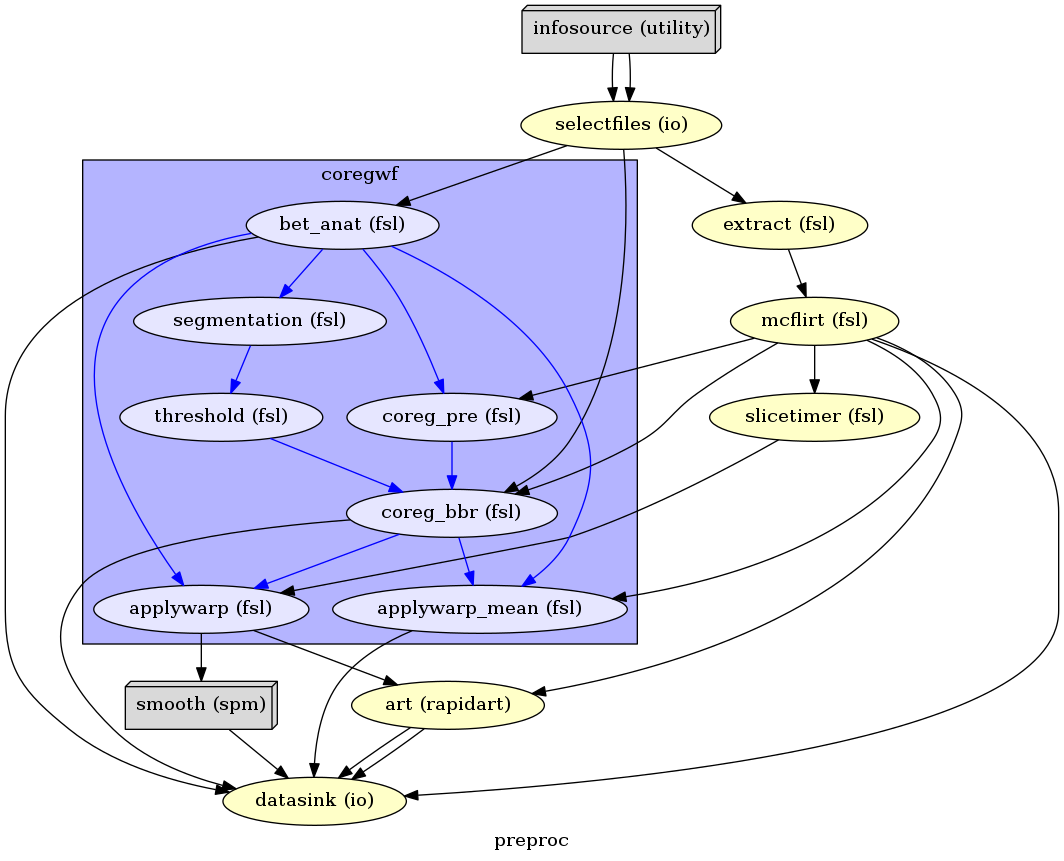

In [10]:
# Create preproc output graph
preproc.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(preproc.base_dir, 'preproc', 'graph.dot.png'))

170903-22:16:50,890 workflow INFO:
	 Generated workflow graph: /output/workingdir/preproc/graph.dot.png (graph2use=flat, simple_form=True).


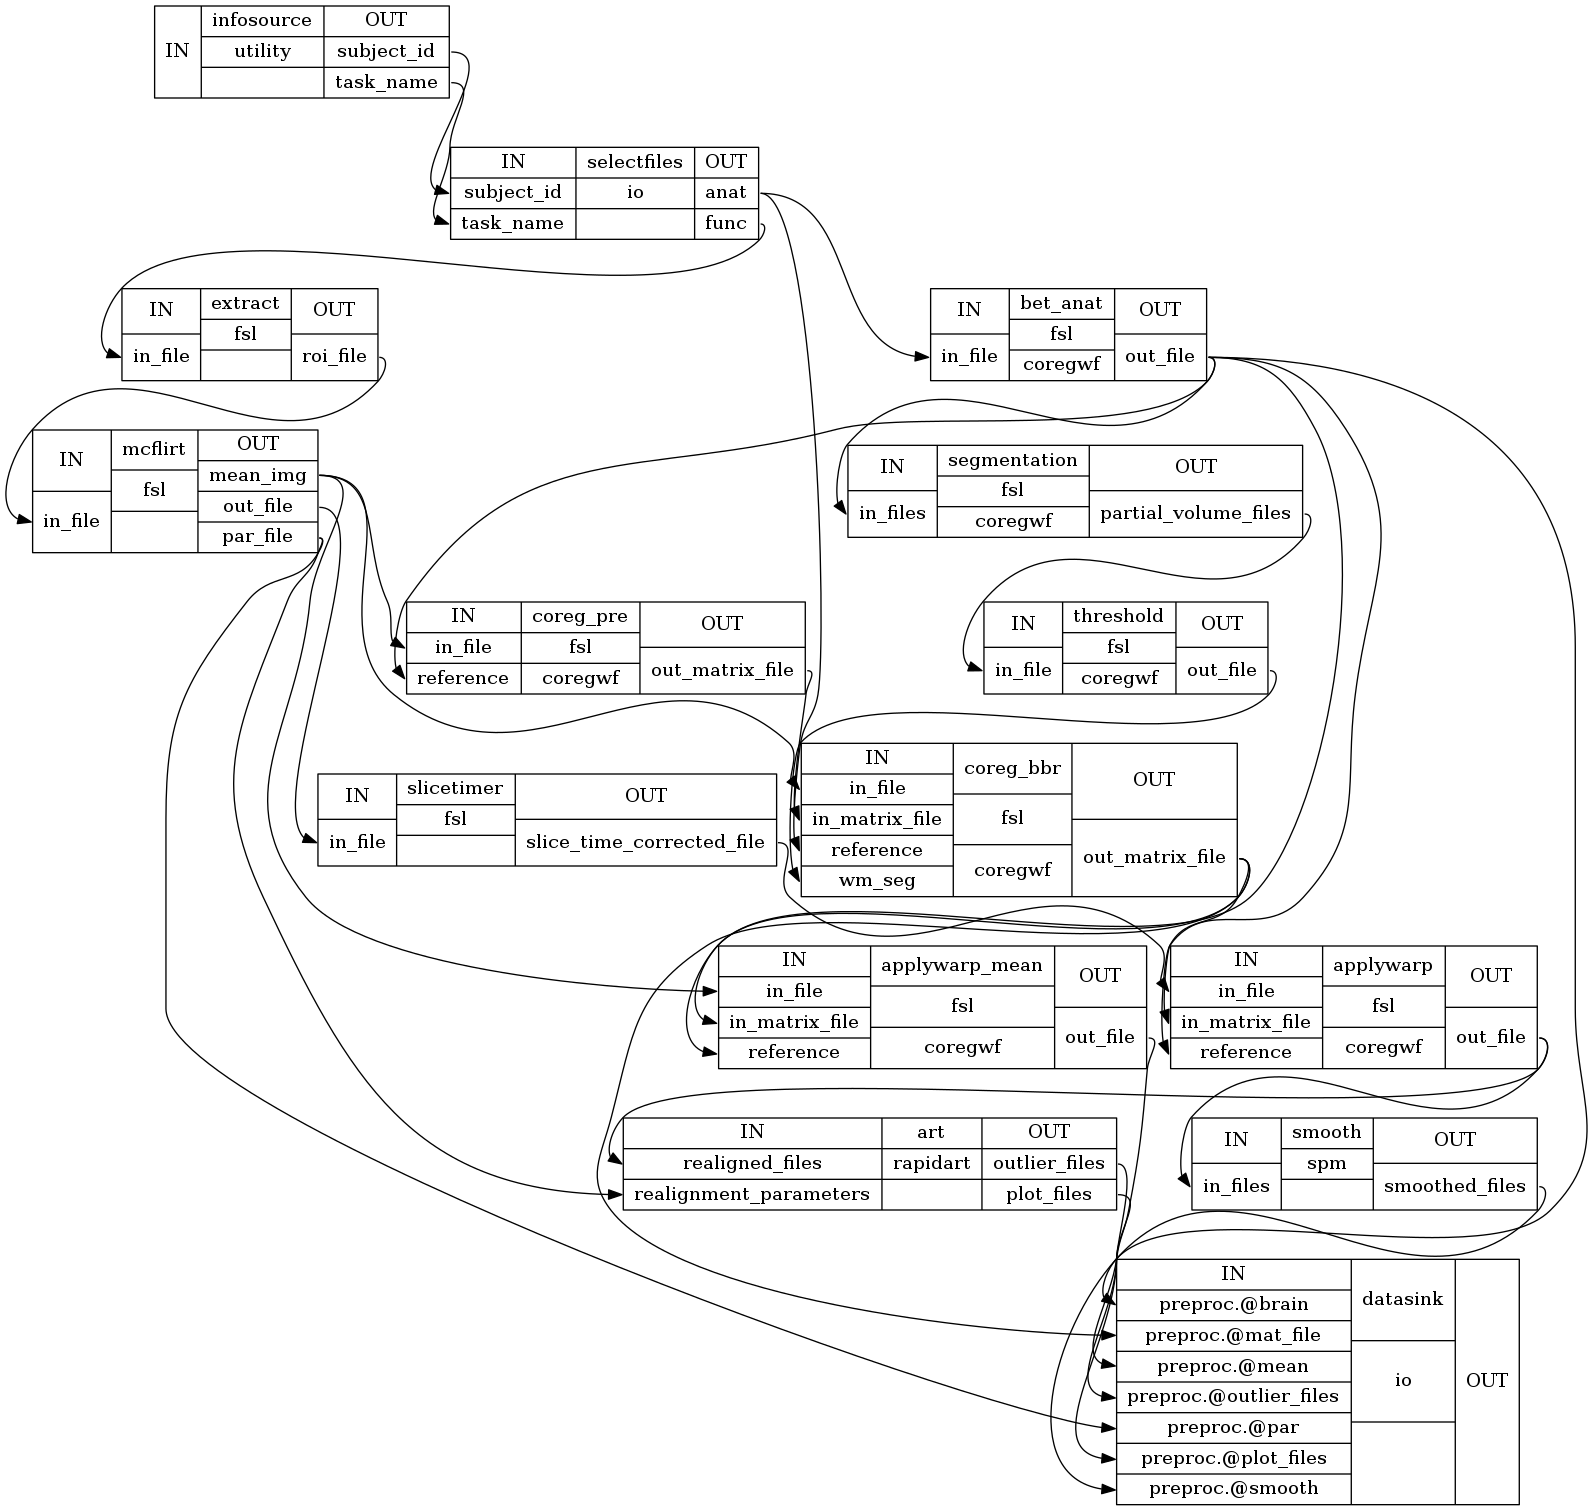

In [11]:
# Visualize the detailed graph
preproc.write_graph(graph2use='flat', format='png', simple_form=True)
Image(filename=opj(preproc.base_dir, 'preproc', 'graph_detailed.dot.png'))

##  Run the Workflow

Now that everything is ready, we can run the preprocessing workflow. Change ``n_procs`` to the number of jobs/cores you want to use. **Note** that if  you're using a Docker container and FLIRT fails to run without any good reason, you might need to change memory settings in the Docker preferences (6 GB should be enough for this workflow).

In [ ]:
preproc.run('MultiProc', plugin_args={'n_procs': 4})

## Inspect output

Let's check the structure of the output folder, to see if we have everything we wanted to save.

In [12]:
!tree /output/datasink/preproc

/output/datasink/preproc
├── sub-01
│   └── task-fingerfootlips
│       ├── art.sub-01_ses-test_task-fingerfootlips_bold_outliers.txt
│       ├── fwhm-4_ssub-01_ses-test_task-fingerfootlips_bold.nii.gz
│       ├── fwhm-8_ssub-01_ses-test_task-fingerfootlips_bold.nii.gz
│       ├── plot.sub-01_ses-test_task-fingerfootlips_bold.png
│       ├── plot.sub-01_ses-test_task-fingerfootlips_bold.svg
│       ├── sub-01_ses-test_task-fingerfootlips_bold_mean.mat
│       ├── sub-01_ses-test_task-fingerfootlips_bold_mean.nii.gz
│       ├── sub-01_ses-test_task-fingerfootlips_bold.par
│       └── sub-01_t1w_preproc_brain.nii.gz
└── sub-02...sub-10

20 directories, 81 files


## Visualize results

Let's check the effect of the different smoothing kernels.

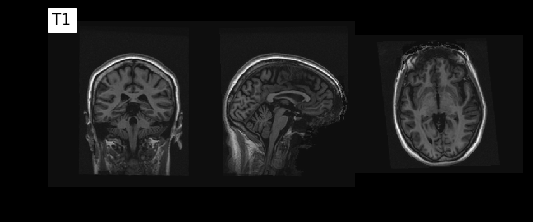

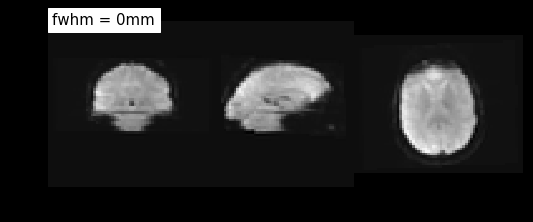

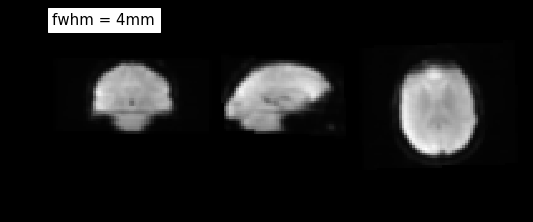

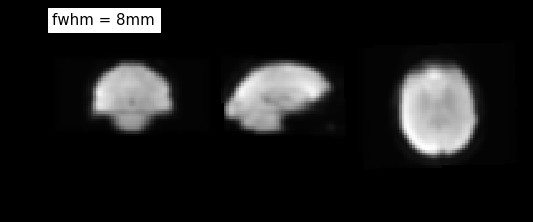

In [16]:
from nilearn import image, plotting
plotting.plot_epi(
    '/data/ds000114/derivatives/fmriprep/sub-01/anat/sub-01_t1w_preproc.nii.gz',
    title="T1", display_mode='ortho', annotate=False, draw_cross=False, cmap='gray')

out_path = '/output/datasink/preproc/sub-01/task-fingerfootlips'
plotting.plot_epi(opj(out_path, 'sub-01_ses-test_task-fingerfootlips_bold_mean.nii.gz'),
                  title="fwhm = 0mm", display_mode='ortho', annotate=False, draw_cross=False, cmap='gray')

plotting.plot_epi(image.mean_img(opj(out_path, 'fwhm-4_ssub-01_ses-test_task-fingerfootlips_bold.nii')),
                  title="fwhm = 4mm", display_mode='ortho', annotate=False, draw_cross=False, cmap='gray')

plotting.plot_epi(image.mean_img(opj(out_path, 'fwhm-8_ssub-01_ses-test_task-fingerfootlips_bold.nii')),
                  title="fwhm = 8mm", display_mode='ortho', annotate=False, draw_cross=False, cmap='gray')

Now, let's investigate the motion parameters. How much did the subject move and turn in the scanner?

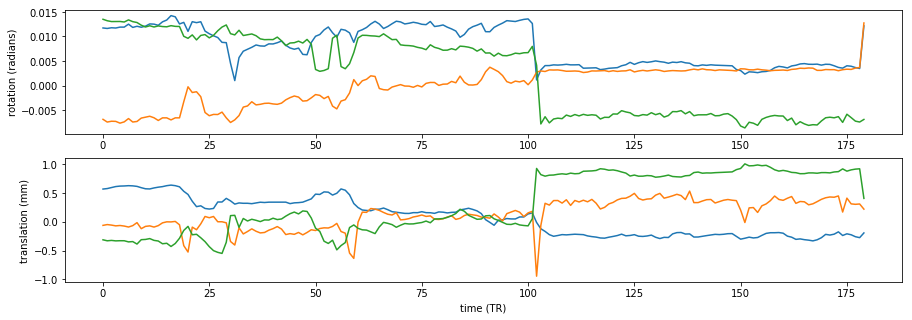

In [17]:
import numpy as np
import pylab as plt
par = np.loadtxt('/output/datasink/preproc/sub-01/task-fingerfootlips/sub-01_ses-test_task-fingerfootlips_bold.par')
fig, axes = plt.subplots(2, 1, figsize=(15, 5))
axes[0].set_ylabel('rotation (radians)')
axes[0].plot(par[0:, :3])
axes[1].plot(par[0:, 3:])
axes[1].set_xlabel('time (TR)')
axes[1].set_ylabel('translation (mm)')

There seems to be a rather drastic motion around volume 102. Let's check if the outliers detection algorithm was able to pick this up.

Outliers were detected at volumes: [  59.  102.]


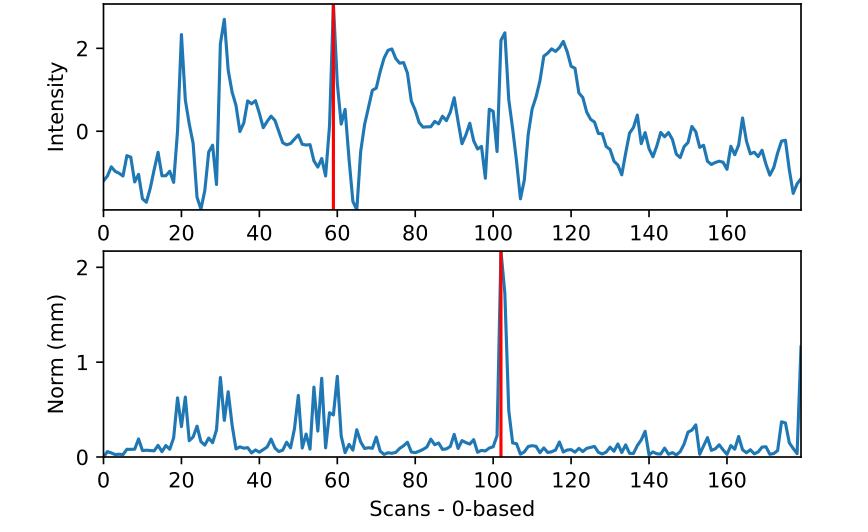

In [3]:
import numpy as np
outlier_ids = np.loadtxt('/output/datasink/preproc/sub-01/task-fingerfootlips/art.sub-01_ses-test_task-fingerfootlips_bold_outliers.txt')
print('Outliers were detected at volumes: %s' % outlier_ids)

from IPython.display import SVG
SVG(filename='/output/datasink/preproc/sub-01/task-fingerfootlips/plot.sub-01_ses-test_task-fingerfootlips_bold.svg')